..\csv\*.csv
Processed data for dalle-2.csv
Processed data for dalle-3.csv
Processed data for hdr.csv
Processed data for midjourney.csv
Processed data for mscoco2014.csv
Processed data for test.csv
Processed data for vqgan.csv


logits_Grag2021_progan           logits_Grag2021_latent  \
                                    accuracy       auc               accuracy   
..\csv\dalle-2.csv                  0.605000  0.959903               0.507000   
..\csv\dalle-3.csv                  0.517500  0.684124               0.857000   
..\csv\hdr.csv                      0.520500  0.772063               0.858000   
..\csv\midjourney.csv               0.531500  0.835863               0.984000   
..\csv\mscoco2014.csv               0.517500  0.684124               0.857000   
..\csv\test.csv                     0.952696  0.959526               0.944182   
..\csv\vqgan.csv                    0.686000  0.944237               0.792000   

                                resnet50nodown_progan            \
                            auc              accuracy       auc   
..\csv\dalle-2.csv     0.658364              0.692000  0.955195   
..\csv\dalle-3.csv     0.853372              0.499000  0.649602   
..\csv\hdr.csv         0.936342              0.493000  0.579278   
..\csv\midjourney.csv  0.994271              0.610500  0.872290   
..\csv\mscoco2014.csv  0.853372              0.499000  0.649602   
..\csv\test.csv        0.713684              0.949858  0.954947   
..\csv\vqgan.csv       0.956349              0.718500  0.935043   

                      resnet50nodown_stylegan2           exif_model      \
                                      accuracy       auc   accuracy auc   
..\csv\dalle-2.csv                    0.503500  0.794980   0.500000 NaN   
..\csv\dalle-3.csv                    0.502500  0.647201   0.500000 NaN   
..\csv\hdr.csv                        0.503500  0.736739   0.500000 NaN   
..\csv\midjourney.csv                 0.505000  0.769751   0.500000 NaN   
..\csv\mscoco2014.csv                 0.502500  0.647201   0.500000 NaN   
..\csv\test.csv                       0.944182  0.777404   0.946074 NaN   
..\csv\vqgan.csv                      0.706500  0.940283   0.500000 NaN   

                      aggregate            
                       accuracy       auc  
..\csv\dalle-2.csv      0.73300  0.733000  
..\csv\dalle-3.csv      0.84600  0.846000  
..\csv\hdr.csv          0.84400  0.844000  
..\csv\midjourney.csv   0.97550  0.975500  
..\csv\mscoco2014.csv   0.84600  0.846000  
..\csv\test.csv         0.94702  0.707298  
..\csv\vqgan.csv        0.88750  0.887500

,logits_Grag2021_progan,logits_Grag2021_latent,resnet50nodown_progan,resnet50nodown_stylegan2,exif_model,aggregate,Dataset
,accuracy,accuracy,accuracy,accuracy,accuracy,accuracy,
0,0.605000,0.507000,0.692000,0.503500,0.500000,0.73300,..\csv\dalle-2.csv
1,0.517500,0.857000,0.499000,0.502500,0.500000,0.84600,..\csv\dalle-3.csv
2,0.520500,0.858000,0.493000,0.503500,0.500000,0.84400,..\csv\hdr.csv
3,0.531500,0.984000,0.610500,0.505000,0.500000,0.97550,..\csv\midjourney.csv
4,0.517500,0.857000,0.499000,0.502500,0.500000,0.84600,..\csv\mscoco2014.csv
5,0.952696,0.944182,0.949858,0.944182,0.946074,0.94702,..\csv\test.csv
6,0.686000,0.792000,0.718500,0.706500,0.500000,0.88750,..\csv\vqgan.csv


,logits_Grag2021_progan,logits_Grag2021_latent,resnet50nodown_progan,resnet50nodown_stylegan2,exif_model,aggregate,Dataset
,auc,auc,auc,auc,auc,auc,
0,0.959903,0.658364,0.955195,0.794980,NaN,0.733000,..\csv\dalle-2.csv
1,0.684124,0.853372,0.649602,0.647201,NaN,0.846000,..\csv\dalle-3.csv
2,0.772063,0.936342,0.579278,0.736739,NaN,0.844000,..\csv\hdr.csv
3,0.835863,0.994271,0.872290,0.769751,NaN,0.975500,..\csv\midjourney.csv
4,0.684124,0.853372,0.649602,0.647201,NaN,0.846000,..\csv\mscoco2014.csv
5,0.959526,0.713684,0.954947,0.777404,NaN,0.707298,..\csv\test.csv
6,0.944237,0.956349,0.935043,0.940283,NaN,0.887500,..\csv\vqgan.csv


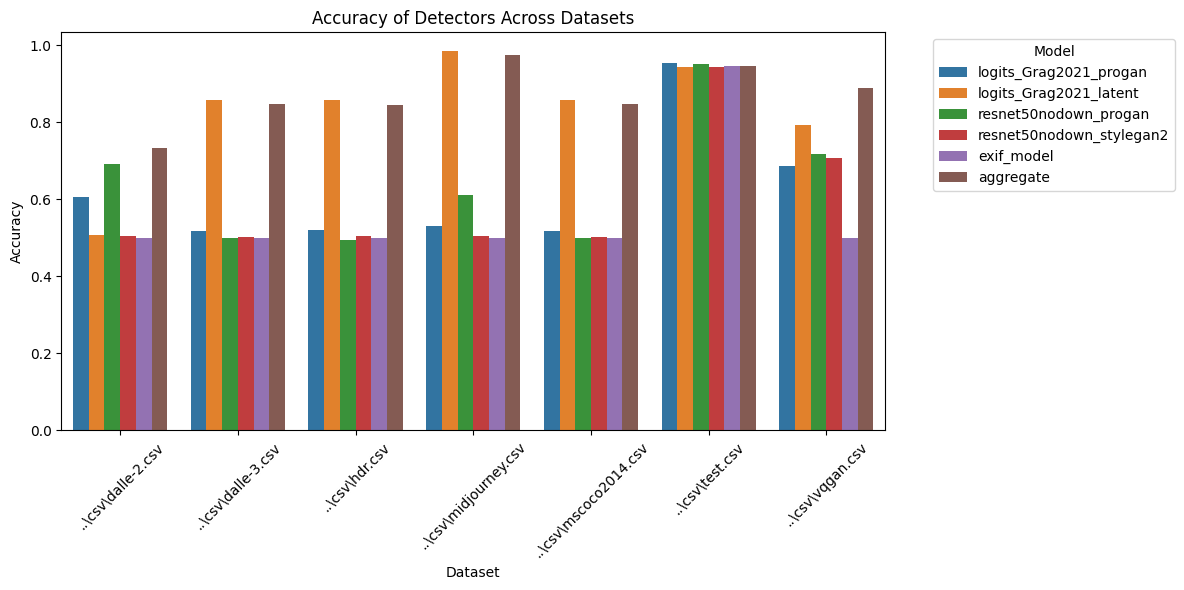

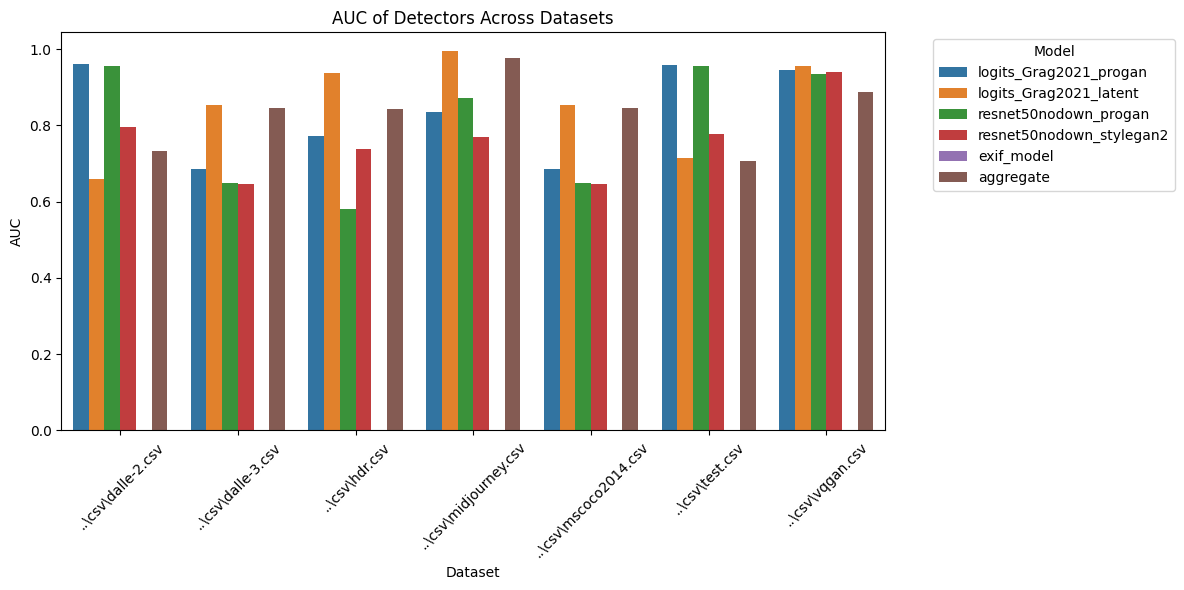

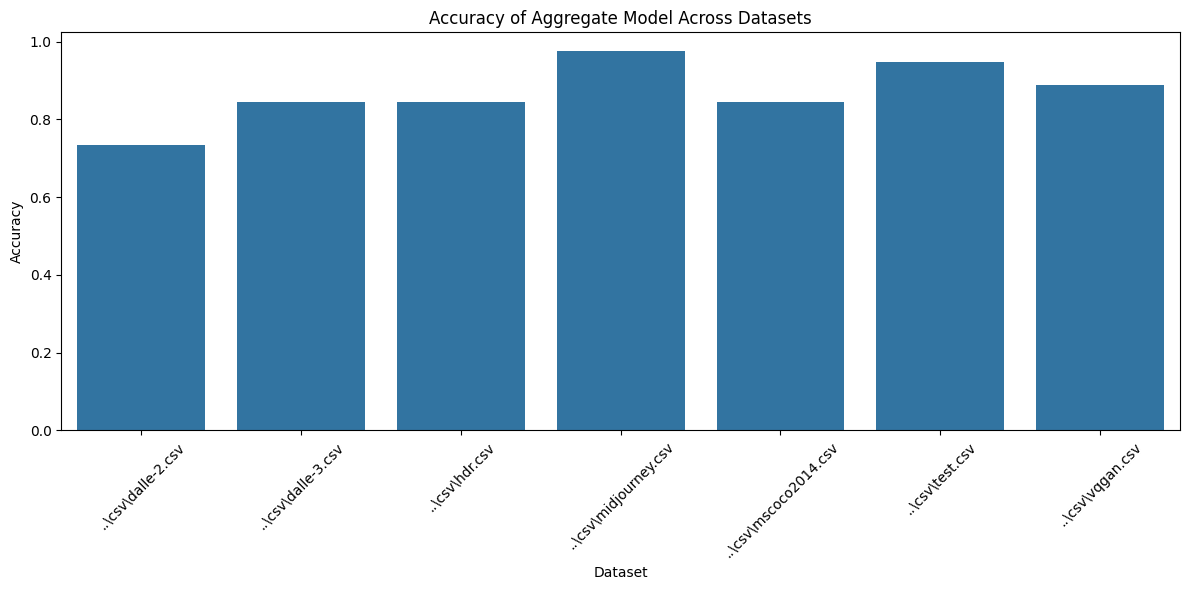

In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, roc_auc_score
from pathlib import Path

# Define the CSV folder path and CSV files
folder_path = "..\csv\\"
mscoco2014_csv = os.path.join(folder_path, 'mscoco2014.csv')
dalle3_csv = os.path.join(folder_path, 'dalle-3.csv')

# Define the threshold for considering an image as synthetic
probability_threshold = 0.2

# CSV mapping
model_columns = {
    'logits_Grag2021_progan': 'dMDetectorResultsinferenceResults_logits_Grag2021_progan',
    'logits_Grag2021_latent': 'dMDetectorResultsinferenceResults_logits_Grag2021_latent',
    'resnet50nodown_progan': 'gANDetectorResultsinferenceResults_logits_gandetection_resnet50nodown_progan',
    'resnet50nodown_stylegan2': 'gANDetectorResultsinferenceResults_logits_gandetection_resnet50nodown_stylegan2',
    'exif_model': 'exifDetectorResultsinferenceResults_isSyntheticImage'
}

# Load MSCOCO2014 and DALLE-3 dataset results
df_mscoco2014 = pd.read_csv(mscoco2014_csv)
df_dalle3 = pd.read_csv(dalle3_csv)

def logits_to_probabilities(logits):
    return 1 / (1 + np.exp(-logits))

def calculate_model_performance(df, threshold):
    performances = {}
    for model_name, column in model_columns.items():
        if 'exif' not in model_name:
            # Convert logits to probabilities for non-exif models
            prob_column = f'{model_name}_prob'
            df[prob_column] = logits_to_probabilities(df[column])
            # Make predictions based on the threshold
            pred_column = f'{model_name}_pred'
            df[pred_column] = df[prob_column] > threshold
            # Calculate accuracy and AUC
            auc_score = roc_auc_score(df['true_label'], df[prob_column])
        else:
            # Use the output directly for exif model
            pred_column = column
            # AUC is not applicable for exif model
            auc_score = np.nan

        performances[model_name] = {
            'accuracy': accuracy_score(df['true_label'], df[pred_column]),
            'auc': auc_score
        }

    # Aggregate results
    prediction_columns = [f'{model}_pred' for model in model_columns.keys() if 'exif' not in model]
    df['final_pred'] = df[prediction_columns].any(axis=1)
    performances['aggregate'] = {
        'accuracy': accuracy_score(df['true_label'], df['final_pred']),
        'auc': roc_auc_score(df['true_label'], df[prediction_columns].max(axis=1))
    }

    return performances

# Construct the pattern to match all CSV files in the folder
pattern = os.path.join(folder_path, '*.csv')
print(pattern)

# Use glob to find all files matching the pattern
csv_files = glob.glob(pattern)

# List of CSV files for each dataset
performance_across_datasets = {model: {'accuracy': [], 'auc': []} for model in ['logits_Grag2021_progan', 'logits_Grag2021_latent', 'resnet50nodown_progan', 'resnet50nodown_stylegan2', 'exif_model', 'aggregate']}

# Loop through each CSV file
for csv_file_path in csv_files:
    csv_file_name = os.path.basename(csv_file_path)
    df = pd.read_csv(csv_file_path)

    # Check dataset name for merging
    if csv_file_name in ['mscoco2014.csv', 'hdr.csv']:
        merged_df = pd.concat([df, df_dalle3], ignore_index=True)
    else:
        merged_df = pd.concat([df, df_mscoco2014], ignore_index=True)

    # Applying sigmoid function to convert logits to probabilities
    for model_name, column in model_columns.items():
        if 'exif' not in model_name:
            merged_df[f'{model_name}_prob'] = logits_to_probabilities(merged_df[column])

    # Calculate model performance
    model_performances = calculate_model_performance(merged_df, probability_threshold)

    # Store accuracies and AUC for each model across datasets
    for model, perf in model_performances.items():
        performance_across_datasets[model]['accuracy'].append(perf['accuracy'])
        performance_across_datasets[model]['auc'].append(perf['auc'])

    print(f"Processed data for {csv_file_name}")

# Convert performance data to DataFrame for plotting
performance_df = pd.DataFrame({
    (model, metric): values
    for model, metrics in performance_across_datasets.items()
    for metric, values in metrics.items()
}, index=csv_files)
display(performance_df)

# Renaming the first column to 'Dataset'
performance_df.reset_index(inplace=True)
performance_df.rename(columns={'index': 'Dataset'}, inplace=True)

# Splitting your DataFrame into separate DataFrames for Accuracy and AUC
accuracy_df = performance_df.filter(like='accuracy', axis=1).copy()
auc_df = performance_df.filter(like='auc', axis=1).copy()

# Adding the 'Dataset' column to both DataFrames
accuracy_df.loc[:, 'Dataset'] = performance_df['Dataset']
auc_df.loc[:, 'Dataset'] = performance_df['Dataset']
display(accuracy_df)
display(auc_df)

# Melting the DataFrames to long format
accuracy_melted = accuracy_df.melt(id_vars='Dataset', var_name='Model', value_name='Accuracy')
auc_melted = auc_df.melt(id_vars='Dataset', var_name='Model', value_name='AUC')

# Removing the '_accuracy' and '_auc' from the 'Model' column
accuracy_melted['Model'] = accuracy_melted['Model'].str.replace('_accuracy', '')
auc_melted['Model'] = auc_melted['Model'].str.replace('_auc', '')

# Plotting Accuracy Across Datasets
plt.figure(figsize=(12, 6))
sns.barplot(x='Dataset', y='Accuracy', hue='Model', data=accuracy_melted)
plt.title('Accuracy of Detectors Across Datasets')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plotting AUC Across Datasets
plt.figure(figsize=(12, 6))
sns.barplot(x='Dataset', y='AUC', hue='Model', data=auc_melted)
plt.title('AUC of Detectors Across Datasets')
plt.xlabel('Dataset')
plt.ylabel('AUC')
plt.xticks(rotation=45)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Filtering for only the 'aggregate' model
aggregate_accuracy = accuracy_melted[accuracy_melted['Model'] == 'aggregate']

# Plotting Accuracy of the Aggregate Model Across Datasets
plt.figure(figsize=(12, 6))
sns.barplot(x='Dataset', y='Accuracy', data=aggregate_accuracy)
plt.title('Accuracy of Aggregate Model Across Datasets')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
